In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

Read in all metrics into a dataframe (per class)

In [3]:

files = os.listdir("/user/christoph.wald/u15287/insect_pest_detection/metrics_collected")

rows = []

for file in files:
    f = os.path.join("/user/christoph.wald/u15287/insect_pest_detection/metrics_collected", file)
    with open(f, "r") as infile:
        data = json.load(infile)
        
        
        # Per-class rows
        for cls, stats in data["per_class"].items():
            row = stats.copy()
            row["file"] = file
            row["class"] = cls
            row["type"] = "per_class"
            rows.append(row)

# Convert to dataframe
df = pd.DataFrame(rows)
df["class"] = df["class"].astype(int)
print(df.head())


     TP   FP   FN  precision    recall              file  class       type
0  1304  199  275   0.867598  0.825839  train1eval1.json      0  per_class
1  1137   82  122   0.932732  0.903098  train1eval1.json      1  per_class
2   883  302  295   0.745148  0.749576  train1eval1.json      2  per_class
3  2228  197  394   0.918763  0.849733  train1eval1.json      3  per_class
4  1366  176  213   0.885863  0.865104  train1eval2.json      0  per_class


In [4]:
# add per class F1-score
df["F1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])


Find training/evaluation with maximum precision, recall and F1 per class

In [5]:
# Function to get row with max for a given column
def max_row_per_class(df, col):
    return df.loc[df.groupby("class")[col].idxmax(), ["class", "file", col]]

# Max precision per class
max_precision = max_row_per_class(df, "precision")
print("Max precision per class:")
print(max_precision)

# Max recall per class
max_recall = max_row_per_class(df, "recall")
print("\nMax recall per class:")
print(max_recall)

# Max F1 per class
max_f1 = max_row_per_class(df, "F1")
print("\nMax F1 per class:")
print(max_f1)

Max precision per class:
    class              file  precision
32      0  train6eval5.json   0.897644
45      1  train7eval5.json   0.943299
30      2  train6eval4.json   0.817450
23      3  train3eval4.json   0.947786

Max recall per class:
    class              file    recall
12      0  train2eval3.json  0.899937
17      1  train3eval3.json  0.938840
14      2  train2eval3.json  0.786927
15      3  train2eval3.json  0.887872

Max F1 per class:
    class              file        F1
36      0  train7eval3.json  0.876678
17      1  train3eval3.json  0.930709
2       2  train1eval1.json  0.747355
39      3  train7eval3.json  0.903478


Calculate total F1 values (without thrips)

In [6]:
classes_to_use = [0, 1, 3]
df_subset = df[df["class"].isin(classes_to_use)]

def micro_f1_per_file(group):
    TP_total = group["TP"].sum()
    FP_total = group["FP"].sum()
    FN_total = group["FN"].sum()
    
    precision_micro = TP_total / (TP_total + FP_total)
    recall_micro = TP_total / (TP_total + FN_total)
    micro_f1 = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
    return pd.Series({
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "micro_F1": micro_f1
    })

micro_metrics = df_subset.groupby("file", as_index=False).apply(micro_f1_per_file)
print(micro_metrics)


                file  precision_micro  recall_micro  micro_F1
0   train1eval1.json         0.907130      0.855128  0.880362
1   train1eval2.json         0.917565      0.872527  0.894480
2   train1eval3.json         0.922354      0.826740  0.871934
3   train2eval3.json         0.898760      0.902381  0.900567
4   train3eval3.json         0.903053      0.893956  0.898481
5   train3eval4.json         0.922236      0.834066  0.875938
6   train6eval3.json         0.918244      0.835165  0.874736
7   train6eval4.json         0.927878      0.822344  0.871929
8   train6eval5.json         0.930130      0.772894  0.844253
9   train7eval3.json         0.907590      0.895788  0.901650
10  train7eval4.json         0.922496      0.850183  0.884865
11  train7eval5.json         0.928495      0.799084  0.858943


/mnt/lustre-emmy-hdd/tmp/u15287/ipykernel_886281/1330414860.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  micro_metrics = df_subset.groupby("file", as_index=False).apply(micro_f1_per_file)


In [7]:
micro_metrics.sort_values("micro_F1", ascending = False)

,file,precision_micro,recall_micro,micro_F1
9,train7eval3.json,0.907590,0.895788,0.901650
3,train2eval3.json,0.898760,0.902381,0.900567
4,train3eval3.json,0.903053,0.893956,0.898481
1,train1eval2.json,0.917565,0.872527,0.894480
10,train7eval4.json,0.922496,0.850183,0.884865
0,train1eval1.json,0.907130,0.855128,0.880362
5,train3eval4.json,0.922236,0.834066,0.875938
6,train6eval3.json,0.918244,0.835165,0.874736
2,train1eval3.json,0.922354,0.826740,0.871934
7,train6eval4.json,0.927878,0.822344,0.871929


plot precision and recall per class and training/evaluation

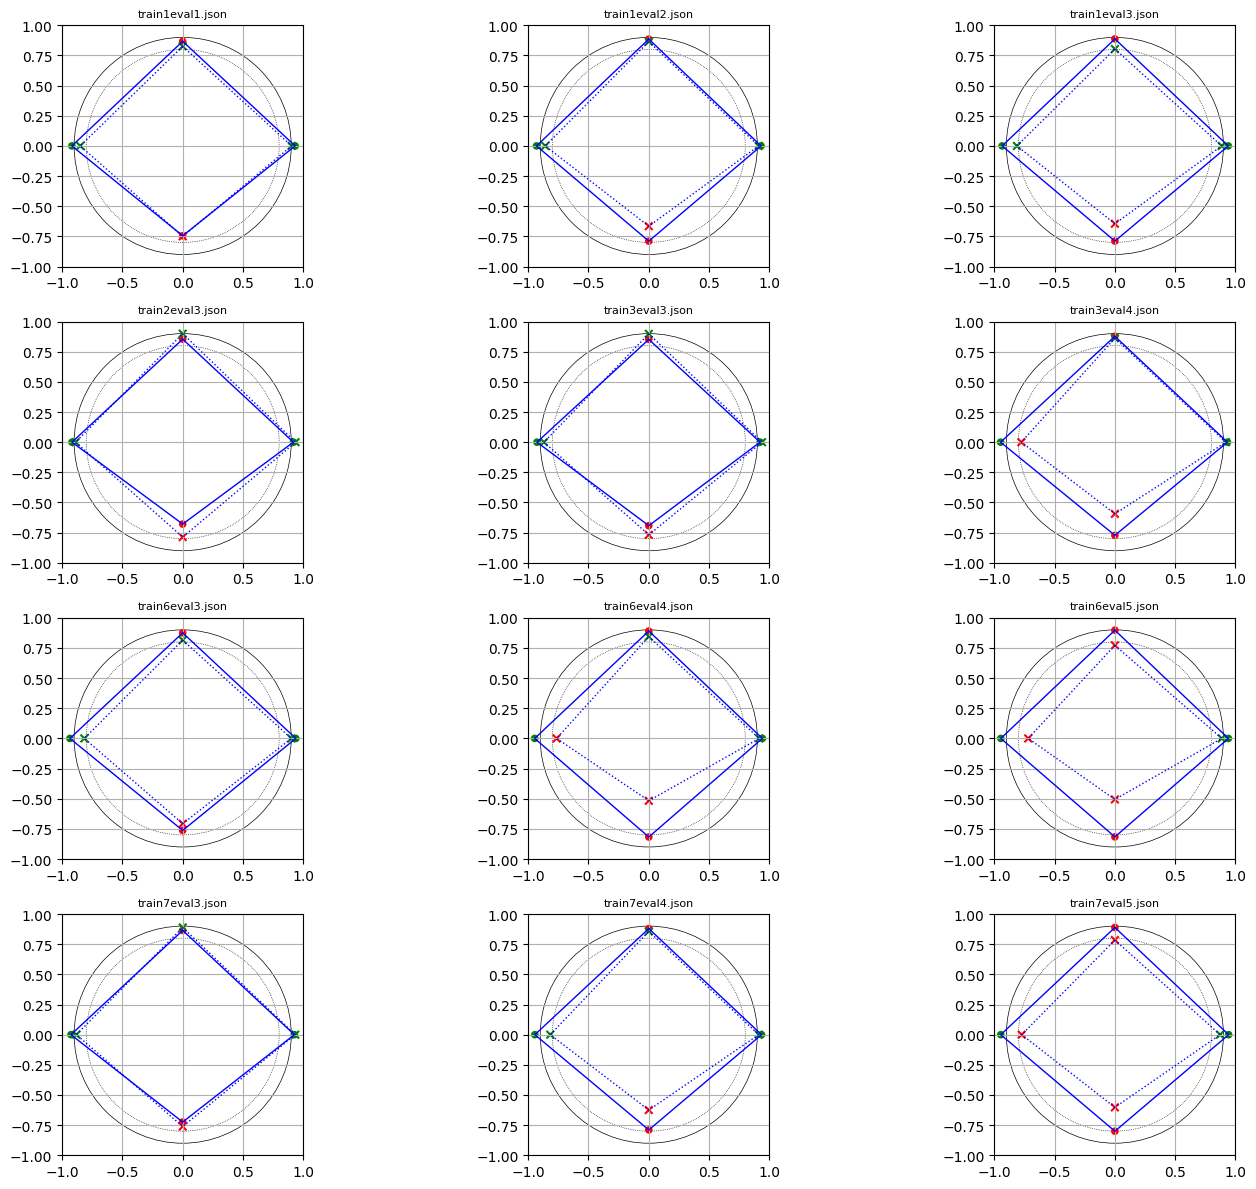

In [11]:
import matplotlib.pyplot as plt

def plot_precision_recall_on_ax(df, file_name, ax):
    """
    Plots precision and recall for the four classes of a given file on a given axis.
    """
    # Create reference circles
    circle1 = plt.Circle((0, 0), 0.8, color='black', linestyle='dotted', fill=False, linewidth=0.5)
    circle2 = plt.Circle((0, 0), 0.9, color='black', linestyle='solid', fill=False, linewidth=0.5)
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    # Filter group
    group = df[df["file"] == file_name]

    # Extract precision and recall per class
    prec = [group[group["class"] == i]["precision"].values[0] for i in range(4)]
    rec  = [group[group["class"] == i]["recall"].values[0]    for i in range(4)]

    # Define points for precision and recall
    x_prec = [0, prec[1], 0, -prec[3], 0]
    y_prec = [prec[0], 0, -prec[2], 0, prec[0]]

    x_rec = [0, rec[1], 0, -rec[3], 0]
    y_rec = [rec[0], 0, -rec[2], 0, rec[0]]

    # Plot precision (solid)
    ax.plot(x_prec, y_prec, color='blue', linewidth=1, label='Precision')
    ax.scatter(x_prec[:-1], y_prec[:-1], 
           c=['green' if p >= 0.9 else 'red' for p in prec], 
           marker='o', s=20)

    # Plot recall (dotted)
    ax.plot(x_rec, y_rec, color='blue', linewidth=1, linestyle='dotted', label='Recall')
    ax.scatter(x_rec[:-1], y_rec[:-1], 
           c=['green' if r >= 0.8 else 'red' for r in rec], 
           marker='x', s=30)

    # Axis settings
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.set_title(file_name, fontsize=8)

# --- Create 4x3 grid ---
files = df["file"].unique()
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, f in enumerate(files):
    plot_precision_recall_on_ax(df, f, axes[i])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [23]:
def plot_recall_precision(df, class_names):
    """
    Plots side-by-side barplots for recall and precision with reference lines.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'recall' and 'precision' columns.
        class_names (list): List of class names (in the same order as df rows).
    """
    # Make sure df is aligned with class names
    df = df.copy()
    df["class"] = class_names

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Recall bar plot
    axes[0].bar(df["class"], df["recall"], color="skyblue")
    axes[0].axhline(y=0.8, color="red", linestyle="dotted", linewidth=2)
    axes[0].set_title("Recall (erkannte:tatsächlich vorhandene Schädlinge)")
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel("Recall")

    # Precision bar plot
    axes[1].bar(df["class"], df["precision"], color="lightgreen")
    axes[1].axhline(y=0.9, color="red", linestyle="dotted", linewidth=2)
    axes[1].set_title("Precision (korrekt erkannte:insgesamt erkannte Schädlinge)")
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel("Precision")

    # Für Recall
    axes[0].set_xticklabels([f"{cls}\n{val:.2f}" for cls, val in zip(df["class"], df["recall"])])

    # Für Precision
    axes[1].set_xticklabels([f"{cls}\n{val:.2f}" for cls, val in zip(df["class"], df["precision"])])

    plt.tight_layout()
    plt.savefig("train7eval3.png")
    plt.show()

/mnt/lustre-emmy-hdd/tmp/u15287/ipykernel_886281/2326226508.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([f"{cls}\n{val:.2f}" for cls, val in zip(df["class"], df["recall"])])
/mnt/lustre-emmy-hdd/tmp/u15287/ipykernel_886281/2326226508.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f"{cls}\n{val:.2f}" for cls, val in zip(df["class"], df["precision"])])


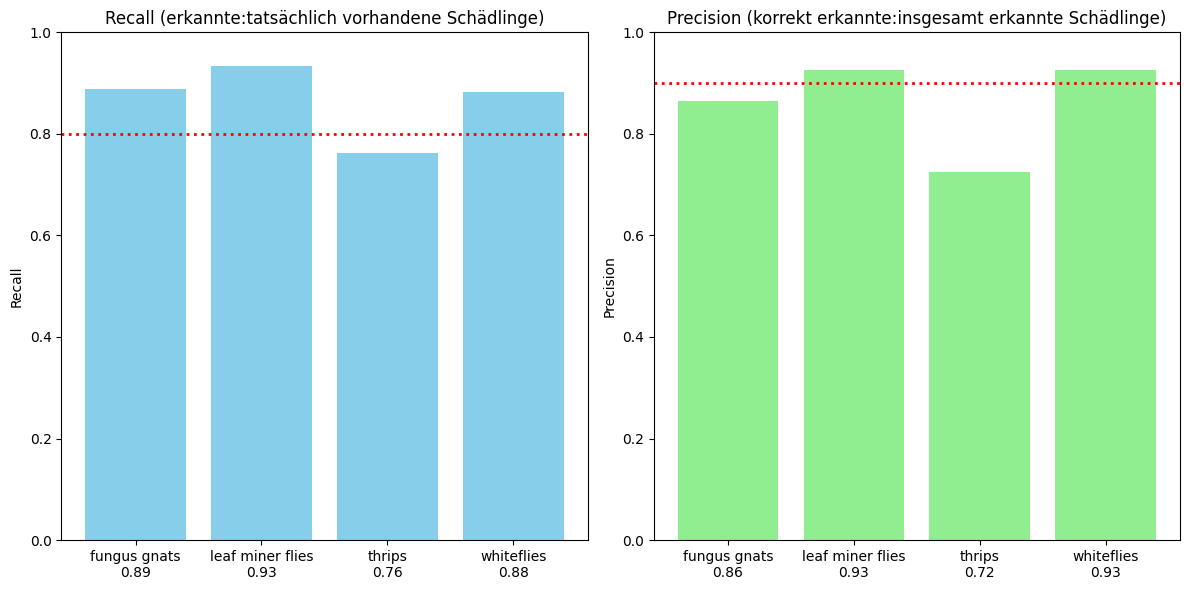

In [24]:
class_names = ["fungus gnats", "leaf miner flies", "thrips", "whiteflies"]
plot_recall_precision(df[df["file"] == "train7eval3.json"], class_names)


In [30]:
import os

def sum_lines_in_files(folder_path, starts_with):
    total_lines = 0

    for filename in os.listdir(folder_path):
        if filename.startswith(starts_with):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    # count lines manually instead of using built-in sum
                    for _ in f:
                        total_lines += 1

    return total_lines


In [46]:
train_instances = []
class_codes = ["BRAIIM", "LIRIBO", "FRANOC", "TRIAVA"]
for code in class_codes:
    total = sum_lines_in_files("/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/labels", code)
    train_instances.append(total)
test_instances = []
for code in class_codes:
    total = sum_lines_in_files("/user/christoph.wald/u15287/big-scratch/02_splitted_data/test_set/labels", code)
    test_instances.append(total)

In [62]:
instances = [i+j for i,j in zip(train_instances, test_instances)]
instances

[6922, 6558, 5453, 11573]

In [58]:
me_train = [160,528,314,160]
labeled_images = [1018, 664, 592,434]
me_test = [40,131,78,40]

In [ ]:
used_images = [i + j for i, j in zip(me_train, me_test)]

used_images

[200, 659, 392, 200]

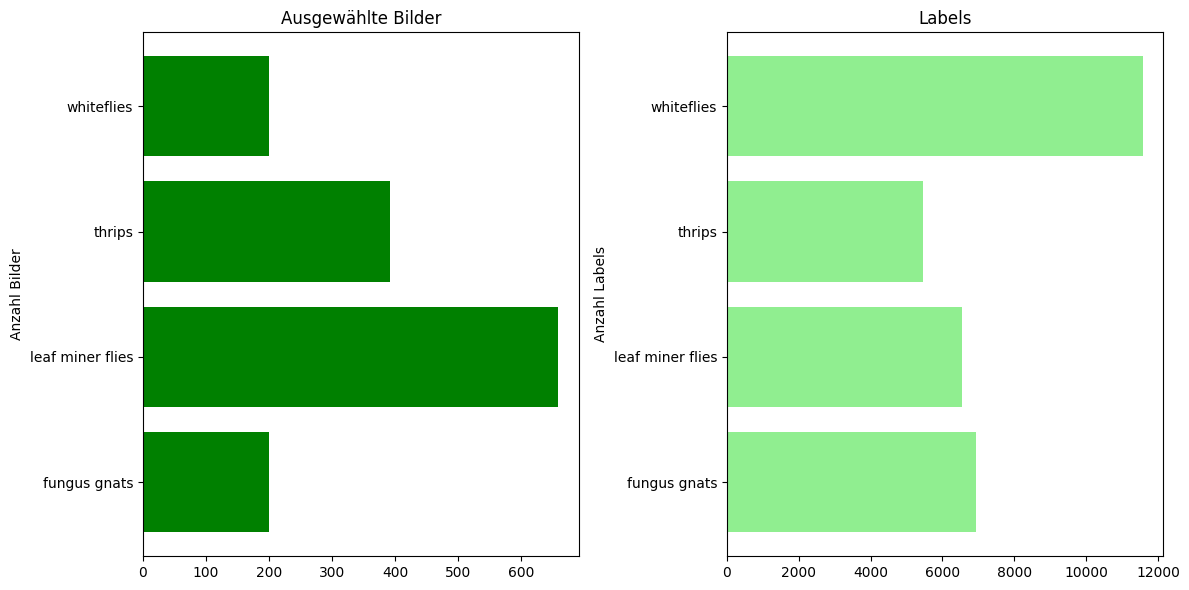

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].barh(class_names, used_images, color="green")
axes[0].set_title("Ausgewählte Bilder")
axes[0].set_ylabel("Anzahl Bilder")

axes[1].barh(class_names, instances, color="lightgreen")
axes[1].set_title("Labels")
axes[1].set_ylabel("Anzahl Labels")

plt.tight_layout()
plt.savefig("anzahl_labels.png")
plt.show()


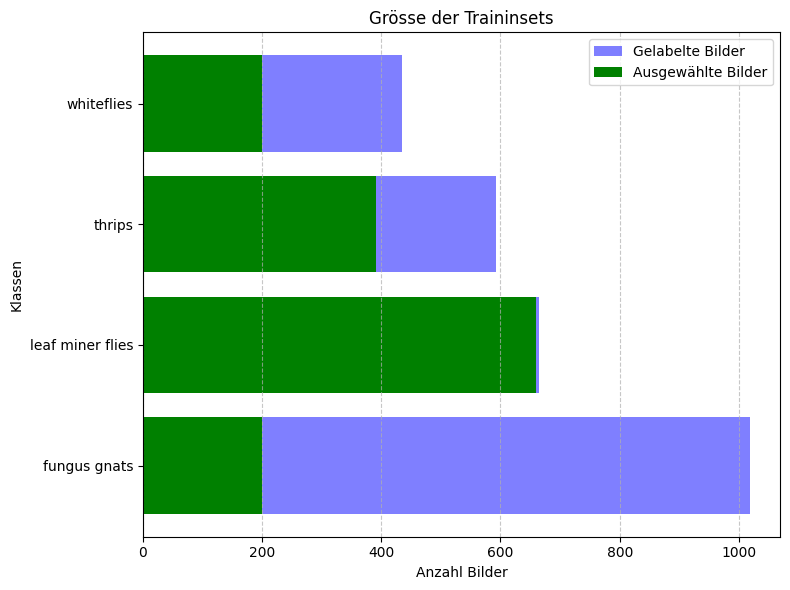

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

# Total
ax.barh(class_names, labeled_images, color="blue", alpha=0.5, label="Gelabelte Bilder")

# Plot me_train in the foreground
ax.barh(class_names, used_images, color="green", label="Ausgewählte Bilder")

ax.set_xlabel("Anzahl Bilder")
ax.set_ylabel("Klassen")
ax.set_title("Grösse der Traininsets")
ax.legend()
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.savefig("set_sizes")

plt.tight_layout()
plt.show()
